<h1>Conteúdo<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup</a></span></li><li><span><a href="#Dados" data-toc-modified-id="Dados-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Dados</a></span><ul class="toc-item"><li><span><a href="#carrega" data-toc-modified-id="carrega-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>carrega</a></span></li><li><span><a href="#mutual-information-&amp;-entropia" data-toc-modified-id="mutual-information-&amp;-entropia-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>mutual information &amp; entropia</a></span></li></ul></li><li><span><a href="#Modelagem" data-toc-modified-id="Modelagem-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Modelagem</a></span></li></ul></div>

# Setup
---

In [42]:
import datetime
import warnings
import pickle
import gc
import os
import math
import pprint
import hashlib
import functools
import tqdm
import joblib

import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.metrics import (classification_report,
                             roc_curve,
                             auc,
                             accuracy_score,
                             confusion_matrix,
                             f1_score,
                             fbeta_score,
                             balanced_accuracy_score,
                             mean_squared_error,
                             r2_score,
                             roc_auc_score)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import lightgbm as lgbm
import optuna

import shap

In [43]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

In [44]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing   import normalize, StandardScaler, LabelBinarizer
from sklearn.metrics         import classification_report, roc_curve, auc,accuracy_score, confusion_matrix, f1_score, fbeta_score
from sklearn.calibration     import CalibratedClassifierCV, calibration_curve
from boruta                  import BorutaPy

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble     import RandomForestClassifier

import lightgbm as lgb  

In [45]:
import pymc3 as pm
import arviz as az

In [46]:
import theano.tensor as tt

In [47]:
from IPython.display import display
%matplotlib inline
warnings.filterwarnings('ignore')

In [48]:
def reduce_mem_usage(df, int_cast=True, obj_to_category=False, subset=None):
    """
    Iterate through all the columns of a dataframe and modify the data type to reduce memory usage.
    :param df: dataframe to reduce (pd.DataFrame)
    :param int_cast: indicate if columns should be tried to be casted to int (bool)
    :param obj_to_category: convert non-datetime related objects to category dtype (bool)
    :param subset: subset of columns to analyse (list)
    :return: dataset with the column dtypes adjusted (pd.DataFrame)
    """
    start_mem = df.memory_usage().sum() / 1024 ** 2;
    gc.collect()
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    cols = subset if subset is not None else df.columns.tolist()

    for col in tqdm.tqdm(cols):
        try:
            col_type = df[col].dtype

            if col_type != object and col_type.name != 'category' and 'datetime' not in col_type.name:
                c_min = df[col].min()
                c_max = df[col].max()

                # test if column can be converted to an integer
                treat_as_int = str(col_type)[:3] == 'int'
                if int_cast and not treat_as_int:
                    treat_as_int = (df[col].fillna(-9999) % 1  == 0).all()

                if treat_as_int:
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.uint8).min and c_max < np.iinfo(np.uint8).max:
                        df[col] = df[col].astype(np.uint8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.uint16).min and c_max < np.iinfo(np.uint16).max:
                        df[col] = df[col].astype(np.uint16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.uint32).min and c_max < np.iinfo(np.uint32).max:
                        df[col] = df[col].astype(np.uint32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)
                    elif c_min > np.iinfo(np.uint64).min and c_max < np.iinfo(np.uint64).max:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        #df[col] = df[col].astype(np.float16)
                        pass
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)
            elif 'datetime' not in col_type.name and obj_to_category:
                df[col] = df[col].astype('category')
        except Exception as e:
            print(col, e)
            pass
    gc.collect()
    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage after optimization is: {:.3f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

# Dados
---

## carrega

In [49]:
df = pd.read_parquet("data/04_model_input/vars_finais.pq")

In [50]:
%%time
df = df.drop_duplicates()
df = df.dropna(subset=["TARGET_7"])

CPU times: user 21.1 ms, sys: 0 ns, total: 21.1 ms
Wall time: 20.5 ms


In [51]:
df.head()

,CODMUN_IBGE,NM_MUNICIPIO,ESTADO,UF,CAPITAL,MACRO_REGIAO,LAT_MUNICIPIO,LONG_MUNICIPIO,POPULACAO_AVG_DECADA,IBGE_DU,...,IBGE_DU_URBAN_DIV_TOTAL,IBGE_DU_RURAL_DIV_TOTAL,IBGE_1_DIV_POP,IBGE_1-4_DIV_POP,IBGE_10-14_DIV_POP,IBGE_15-59_DIV_POP,IBGE_5-9_DIV_POP,IBGE_60+_DIV_POP,IFOOD_COUNT_DIV_POP,DENSIDADE_POP
0,1200013,Acrelandia,Acre,AC,False,Norte,-9.82581,-66.8972,14087.6,3473,...,0.483444,0.516556,0.019993,0.086073,0.120298,0.590308,0.113690,0.069637,NaN,7.563814
1,1200054,Assis Brasil,Acre,AC,False,Norte,-10.92980,-69.5738,6842.8,1458,...,0.683128,0.316872,0.018899,0.095590,0.109285,0.602849,0.109011,0.064366,NaN,1.325973
2,1200104,Brasileia,Acre,AC,False,Norte,-10.99500,-68.7497,24212.8,5973,...,0.700151,0.299849,0.018121,0.074230,0.110327,0.618223,0.101812,0.077287,0.000041,5.968476
3,1200138,Bujari,Acre,AC,False,Norte,-9.81528,-67.9550,9489.0,2332,...,0.442967,0.557033,0.020619,0.078405,0.120727,0.591427,0.114759,0.074064,0.000105,3.039589
5,1200203,Cruzeiro Do Sul,Acre,AC,False,Norte,-7.62762,-72.6756,83165.9,18439,...,0.734422,0.265578,0.018977,0.081194,0.121907,0.601898,0.108561,0.067463,0.000529,9.281476


In [52]:
drop_vars_ = [
    'CODMUN_IBGE', 'NM_MUNICIPIO', 'ESTADO', 'UF',
    #     'CAPITAL',
    'MACRO_REGIAO',
    #     'LAT_MUNICIPIO', 'LONG_MUNICIPIO',
    "AG_2015",
    "AG_2016",
    "AG_2017",
    "AG_2018",
    "AG_2019",
    "AG_2020",
    "AG_2021",
    "AG_OP_2015",
    "AG_OP_2016",
    "AG_OP_2017",
    "AG_OP_2018",
    "AG_OP_2019",
    "AG_OP_2020",
    "AG_OP_2021",
    "AG_CL_2015",
    "AG_CL_2016",
    "AG_CL_2017",
    "AG_CL_2018",
    "AG_CL_2019",
    "AG_CL_2020",
    "AG_CL_2021",
    "TARGET_8_2015",
    "TARGET_8_2016",
    "TARGET_8_2017",
    "TARGET_8_2018",
    "TARGET_8_2019",
    "TARGET_8_2020",
    "TARGET_8_2021",
    #     'POPULACAO_AVG_DECADA',
    'IDHM RANKING 2010',
    "APROX_AREA_KM2",

    "IBGE_1_DIV_POP",
    "IBGE_1-4_DIV_POP",
    "IBGE_5-9_DIV_POP",
    "IBGE_15-59_DIV_POP",

    # "FX_VEL_0KBPS A 512KBPS",
    "FX_VEL_12MBPS A 34MBPS",
    "FX_VEL_2MBPS A 12MBPS",
    "FX_VEL_512KBPS A 2MBPS",
    # "FX_VEL_> 34MBPS",
    "TEC_ATM",
    "TEC_CABLE MODEM",
    "TEC_DTH",
    "TEC_ETHERNET",
    "TEC_FR",
    "TEC_FWA",
    # "TEC_FIBRA",
    "TEC_HFC",
    "TEC_LTE",
    "TEC_MMDS",
    "TEC_PLC",
    # "TEC_VSAT",
    "TEC_WIMAX",
    "TEC_WI-FI",
    "TEC_XDSL",
    "IBGE_DU_RURAL_DIV_TOTAL",

    "IBGE_CROP_PRODUCTION_$",
    "IBGE_PLANTED_AREA",
    'IBGE_DU_URBAN', 'IBGE_DU_RURAL', 'IBGE_DU',
    'IBGE_1', 'IBGE_1-4', 'IBGE_10-14', 'IBGE_15-59', 'IBGE_5-9', 'IBGE_60+',
    'IBGE_DU_URBAN', 'IBGE_DU_RURAL', 'IBGE_DU',
    "IFOOD_COUNT",
    "GVA_TOTAL",
    'PR_AGENCIES', 'PU_AGENCIES',  'PR_ASSETS', 'PU_ASSETS',
    'CARS', 'MOTORCYCLES', 'WHEELED_TRACTOR',
    'PRIV_BANK_ASSETS_DIV_AGENCIES',
    'PUBL_BANK_ASSETS_DIV_AGENCIES' 

]

df = df.drop(columns=drop_vars_, errors="ignore")

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3685 entries, 0 to 5571
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CAPITAL                    3685 non-null   bool   
 1   LAT_MUNICIPIO              3685 non-null   float64
 2   LONG_MUNICIPIO             3685 non-null   float64
 3   POPULACAO_AVG_DECADA       3685 non-null   float64
 4   IDHM                       3685 non-null   float64
 5   IDHM_RENDA                 3685 non-null   float64
 6   IDHM_LONGEVIDADE           3685 non-null   float64
 7   IDHM_EDUCACAO              3685 non-null   float64
 8   GVA_AGROPEC                3684 non-null   float64
 9   GVA_INDUSTRY               3684 non-null   float64
 10  GVA_SERVICES               3684 non-null   float64
 11  GVA_PUBLIC                 3684 non-null   float64
 12  GDP_CAPITA                 3685 non-null   float64
 13  UBER                       3685 non-null   int64

## mutual information & entropia

In [54]:
scipy.stats.entropy(df["TARGET_7"].value_counts(normalize=True).values)

0.8150612653924044

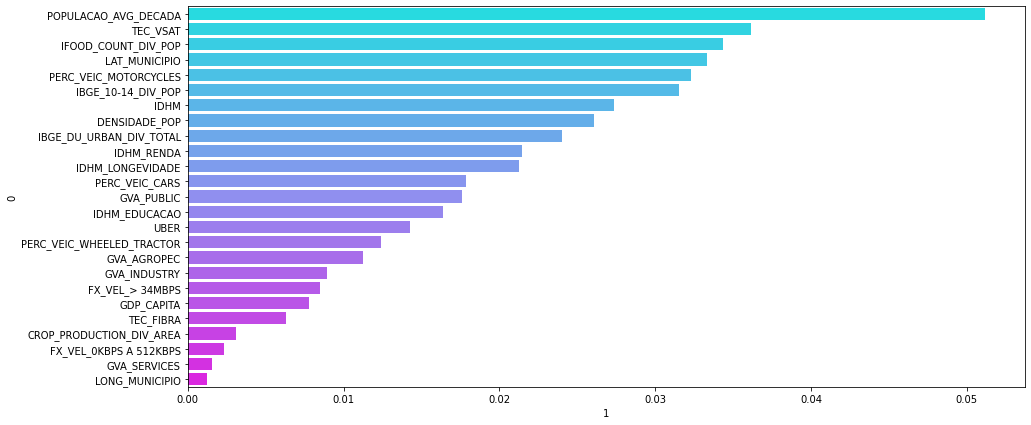

In [55]:
X = df.drop(columns=set(drop_vars_+["TARGET_7"]), errors="ignore").select_dtypes("number")
X_cols = X.columns

mut = mutual_info_classif(
    X.fillna(-1),
    np.where(df["TARGET_7"].values==-1, 1, 0)
)
mut = pd.DataFrame([X_cols, mut]).T.sort_values(by=[1], ascending=[False])

f, ax1 = plt.subplots(figsize=(15, 7))

g = sns.barplot(
    data=mut.loc[mut[1]>0],
    x=1, 
    y=0,
    ax=ax1, 
    palette="cool",
    orient="h"
)

# Modelagem
---

In [56]:
tag = "logreg"

In [57]:
df = pd.read_parquet("data/04_model_input/vars_finais.pq")

df = df.dropna(subset=["TARGET_7"])

In [58]:
X_keys = df[['UF', "CODMUN_IBGE"]].copy()

In [59]:
X = df.drop(columns=set(drop_vars_+["TARGET_7"]), errors="ignore").copy()

y = df[["TARGET_7"]].copy()
y["TARGET_7"] = np.where(y["TARGET_7"]==-1, 1, 0)

In [60]:
y["TARGET_7"].value_counts()

1    1929
0    1757
Name: TARGET_7, dtype: int64

In [61]:
obj_cols = X.select_dtypes("object").columns
X[obj_cols] = X[obj_cols].astype("category")

In [62]:
scaler = StandardScaler()
# scaler = MinMaxScaler()

yy = pd.Categorical(y["TARGET_7"]).codes
xx = pd.DataFrame(scaler.fit_transform( X.fillna(-1) ), columns=X.columns)

In [63]:
# skf = StratifiedKFold(n_splits=3, shuffle=True)

# for train_index, test_index in skf.split(xx, yy):
#     Xt, Xh = xx.iloc[train_index,:], xx.iloc[test_index,:]
#     yt, yh = yy[train_index], yy[test_index]
    
#     print(Xt.shape, Xh.shape, yt.shape, yh.shape)

In [64]:
with pm.Model() as model_reglog:
    data = pm.Data("data", xx.values)
    
    alfa = pm.Normal("alfa", mu=0, sd=10)
    beta = pm.Normal("beta", mu=0, sd=2, shape=xx.shape[1] )

    mu = alfa + pm.math.dot(data, beta)
    teta = pm.Deterministic("teta", pm.math.sigmoid(mu))

    yl = pm.Bernoulli("yl", p=teta, observed=yy)

    trace = pm.sample(100)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alfa]


Sampling 4 chains for 1_000 tune and 100 draw iterations (4_000 + 400 draws total) took 51 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [65]:
gc.collect()

84661

In [66]:
# az.plot_trace(data=trace);

In [67]:
az.summary(trace).T.filter(like="beta").T

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],1.477,1.189,-0.064,3.598,0.093,0.067,195.0,281.0,1.02
beta[1],-0.377,0.086,-0.539,-0.212,0.005,0.003,359.0,313.0,1.01
beta[2],0.017,0.051,-0.071,0.122,0.003,0.003,323.0,180.0,1.00
beta[3],1.583,0.350,0.839,2.209,0.020,0.014,302.0,310.0,1.00
beta[4],-2.097,1.314,-4.371,0.592,0.112,0.081,139.0,206.0,1.02
beta[5],0.821,0.500,-0.119,1.749,0.042,0.030,141.0,182.0,1.01
beta[6],0.346,0.245,-0.133,0.814,0.020,0.014,152.0,202.0,1.01
beta[7],1.158,0.688,-0.192,2.399,0.059,0.042,139.0,214.0,1.02
beta[8],0.300,0.958,-1.106,2.368,0.105,0.077,95.0,156.0,1.04
beta[9],0.474,0.879,-0.846,2.368,0.096,0.070,96.0,162.0,1.04


In [68]:
summary_ = az.summary(trace).copy()
params_ = summary_["mean"].filter(regex="alfa|beta") 
params_

alfa        0.304
beta[0]     1.477
beta[1]    -0.377
beta[2]     0.017
beta[3]     1.583
beta[4]    -2.097
beta[5]     0.821
beta[6]     0.346
beta[7]     1.158
beta[8]     0.300
beta[9]     0.474
beta[10]    0.277
beta[11]    0.716
beta[12]    0.130
beta[13]    0.175
beta[14]   -0.093
beta[15]   -0.029
beta[16]   -0.043
beta[17]   -0.197
beta[18]    2.130
beta[19]    1.924
beta[20]   -0.348
beta[21]   -0.027
beta[22]   -0.077
beta[23]    0.171
beta[24]    0.070
beta[25]    0.043
beta[26]    0.034
Name: mean, dtype: float64

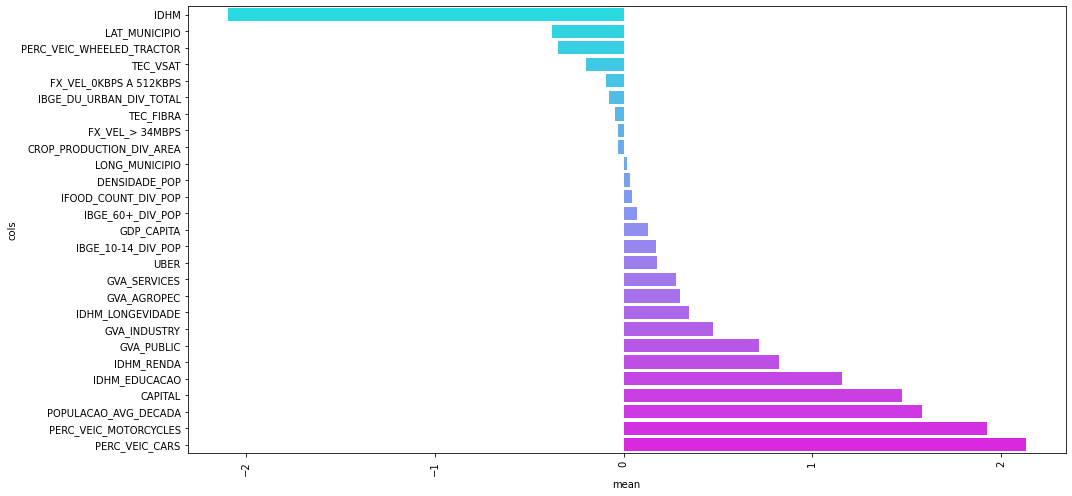

In [120]:
params_ = summary_["mean"].filter(regex="beta") 
params_ = pd.DataFrame(params_)
params_["cols"] = X.columns.values
params_.sort_values(by=["mean"])

f, ax1 = plt.subplots(figsize=(15, 7))
g = sns.barplot(
    data=params_,
    x="mean", 
    y="cols",
    ax=ax1, 
    palette="cool",
    order=params_.sort_values(by=["mean"])["cols"],
    orient="h"
)
plt.xticks(rotation=90)
plt.tight_layout()

In [69]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

In [72]:
cols = xx.columns.tolist()
t_prob = xx.copy()
t_prob["1"] = 1.0
t_prob["true"] = yy

t_prob["dot"] = (params_.values * t_prob[["1"] + cols]).sum(axis=1)
t_prob["prob"] = t_prob["dot"].apply( sigmoid )
t_prob["pred"] = (t_prob["prob"] >= 0.5).astype("int")


In [103]:
T = pd.concat([X_keys.reset_index().drop(columns=["index"]),
               X.reset_index().drop(columns=["index"]),
               t_prob[["true", "pred", "prob"]]], axis=1)

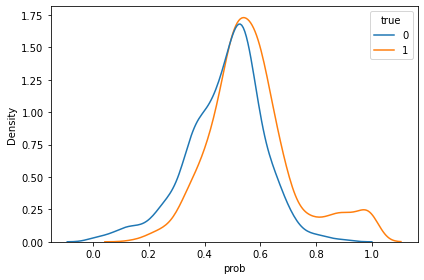

In [105]:
sns.kdeplot(
    data=T,
    x="prob",
    hue="true",
)

plt.tight_layout()

In [106]:
print(classification_report(T["true"], T["pred"]))

print(balanced_accuracy_score(T["true"], T["pred"]))

print(roc_auc_score(T["true"], T["prob"]))

              precision    recall  f1-score   support

           0       0.59      0.52      0.56      1757
           1       0.61      0.67      0.64      1929

    accuracy                           0.60      3686
   macro avg       0.60      0.60      0.60      3686
weighted avg       0.60      0.60      0.60      3686

0.599600413424433
0.6605641420100536


In [121]:
T.to_parquet(rf"data/06_model_output/{tag}.pq")

.